### Import

In [18]:
import torch
import torch.nn
import os
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print(torch.cuda.is_available())
print(torch.__version__)

True
2.5.1+cu121


CPU or CUDA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Sample Image

In [3]:
# with Image.open('train_images/57a3f5f74cbc0d.jpg') as image:
#     image.show()

In [3]:
file_list = []
for root, dirs, files in os.walk("train_images"):
    for file in files:
        file_list.append(file)
file_list

['578bca137dfb9a.jpg',
 '578bd5cb7019d3.jpg',
 '578cccc232dd4f.jpg',
 '578d671b2d2e23.jpg',
 '579c979a7bd0dc.jpg',
 '57a3f5f74cbc0d.jpg',
 '57a59f0adea366.jpg',
 '57a5bbbdd2b761.jpg',
 '57a6939f2db742.jpg',
 '57a745ef9bcd20.jpg',
 '57aa0d9b75c960.jpg',
 '57aa467d8c812d.jpg',
 '57ac994a3e931d.jpg',
 '57ae5993517e2c.jpg',
 '57af9954973517.jpg',
 '57b1db602ebd70.jpg']

### Extract Data

In [4]:
class ExtractDataset(Dataset):
    def __init__(self, data, preprocessor, transform=None):
        self.data = data
        self.preprocessor = preprocessor
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item_image = self.data.loc[idx, "image"]
        item_label = self.data.loc[idx, "individual_id"]
        item_image_path = os.path.join("train_images", item_image)
        if item_image in file_list:
            item_image = Image.open(item_image_path)
        else:
            item_image = Image.open("train_images/57a3f5f74cbc0d.jpg")
        item_tensors = self.preprocessor(images=item_image, return_tensors="pt")
        item = {
            key: value.squeeze() for key, value in item_tensors.items()
        }  # removing batch dimension
        item["labels"] = torch.tensor(item_label)
        return item

In [5]:
train_df = pd.read_csv("train.csv")
le = LabelEncoder()
train_df["individual_id"] = le.fit_transform(train_df["individual_id"])
n_labels = train_df["individual_id"].nunique()

In [6]:
n_labels

15587

### Preprocessing and Model

In [7]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=n_labels,
    id2label={str(i): label for i, label in enumerate(le.classes_)},
    label2id={label: str(i) for i, label in enumerate(le.classes_)},
)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

### Dataset

In [8]:
train_dataset = ExtractDataset(train_df.loc[0:20, :], processor)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
validation_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [9]:
train_loader

### Model Training

In [10]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

# Training
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch +1} / {epochs}")

    # Training
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = {
            key: value.to(device) for key, value in batch.items() if key != "labels"
        }
        labels = batch["labels"].to(device)
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Training Loss: {avg_train_loss}")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(validation_loader):
            inputs = {
                key: value.to(device) for key, value in batch.items() if key != "labels"
            }
            labels = batch["labels"].to(device)
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(validation_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {accuracy}%\n")

Epoch 1 / 10


  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 9.65267311442982


  0%|          | 0/11 [00:00<?, ?it/s]

Validation Loss: 9.443270076404918, Accuracy: 4.761904761904762%

Epoch 2 / 10


  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 9.327363881197842


  0%|          | 0/11 [00:00<?, ?it/s]

Validation Loss: 9.057490175420588, Accuracy: 9.523809523809524%

Epoch 3 / 10


  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 8.960201610218395


  0%|          | 0/11 [00:00<?, ?it/s]

Validation Loss: 8.778440648859197, Accuracy: 9.523809523809524%

Epoch 4 / 10


  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 8.72965483231978


  0%|          | 0/11 [00:00<?, ?it/s]

Validation Loss: 8.5425761829723, Accuracy: 9.523809523809524%

Epoch 5 / 10


  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 8.493816202337092


  0%|          | 0/11 [00:00<?, ?it/s]

Validation Loss: 8.269080465490168, Accuracy: 9.523809523809524%

Epoch 6 / 10


  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 8.20492137562145


  0%|          | 0/11 [00:00<?, ?it/s]

Validation Loss: 8.079941099340266, Accuracy: 9.523809523809524%

Epoch 7 / 10


  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 8.02631053057584


  0%|          | 0/11 [00:00<?, ?it/s]

Validation Loss: 7.821009809320623, Accuracy: 9.523809523809524%

Epoch 8 / 10


  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 7.760194995186546


  0%|          | 0/11 [00:00<?, ?it/s]

Validation Loss: 7.57897459376942, Accuracy: 9.523809523809524%

Epoch 9 / 10


  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 7.502636952833696


  0%|          | 0/11 [00:00<?, ?it/s]

Validation Loss: 7.323896624825218, Accuracy: 9.523809523809524%

Epoch 10 / 10


  0%|          | 0/11 [00:00<?, ?it/s]

Training Loss: 7.197787328199907


  0%|          | 0/11 [00:00<?, ?it/s]

Validation Loss: 7.053854595531117, Accuracy: 9.523809523809524%



In [11]:
# Extract embeddings
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for batch in tqdm(validation_loader):
        inputs = {
            key: value.to(device) for key, value in batch.items() if key != "labels"
        }
        output = model.vit(**inputs)
        last_hidden_states = output.last_hidden_state[:, 0, :]
        embeddings.append(last_hidden_states.cpu().numpy())
        labels.extend(batch["labels"].cpu().numpy())

# Concatenate all embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels = np.array(labels)

  0%|          | 0/11 [00:00<?, ?it/s]

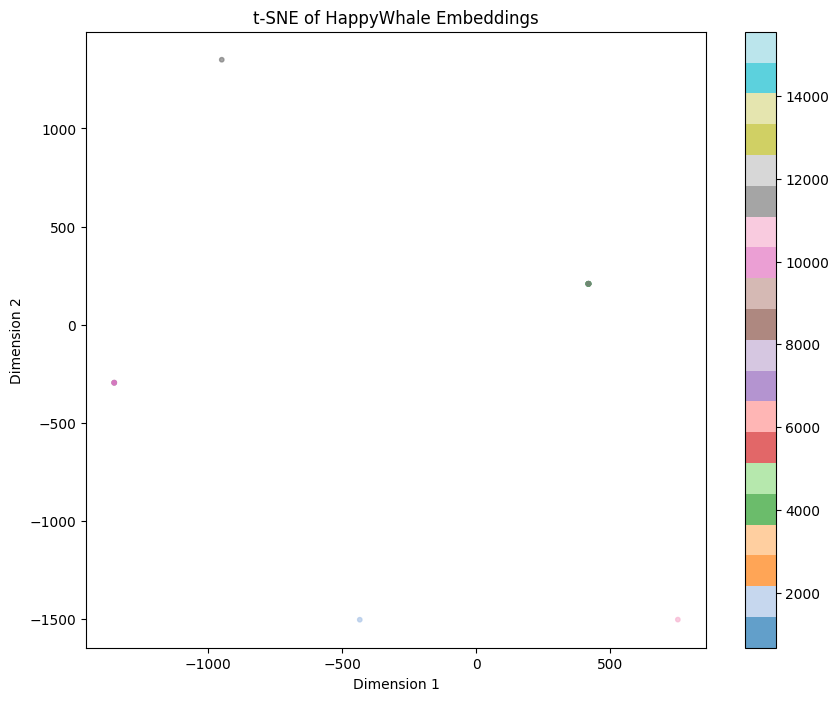

In [20]:
# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="tab20", alpha=0.7, s=10
)
plt.colorbar()
plt.title("t-SNE of Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
model.save_pretrained("re-trained")
processor.save_pretrained("re-trained_processor")
np.save("embeddings.npy", embeddings)
np.save("labels.npy", labels)